In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import boto
import pickle
import requests
import json

In [2]:
# read csv file from AWS cloud
# url = "https://s3-us-west-1.amazonaws.com/nyctaxifaredataset/train.csv"
data_csv = ("train.csv")
df_train = pd.read_csv(data_csv, nrows=500_000, parse_dates=['pickup_datetime'])

In [3]:
# Shape of the Data
df_train.shape

# Create a copy just in case
df_copy = df_train.copy()

In [4]:
# Check types of data
df_train.dtypes

key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [5]:
# Take a quick look at the data
df_train.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45+00:00,-74.000964,40.731630,-73.972892,40.758233,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00+00:00,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00+00:00,-73.951300,40.774138,-73.990095,40.751048,1
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00+00:00,-74.006462,40.726713,-73.993078,40.731628,1
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00+00:00,-73.980658,40.733873,-73.991540,40.758138,2


In [6]:
# Get a summary of the data
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,500000.000000,500000.000000,500000.000000,499995.000000,499995.000000,500000.000000
mean,11.358361,-72.519958,39.920276,-72.522435,39.916526,1.683428
std,9.916617,11.856831,8.073475,11.797362,7.391002,1.307395
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000
25%,6.000000,-73.992047,40.734917,-73.991382,40.734057,1.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


In [7]:
# Check for the missing/null data
df_train.isnull().sum().sort_values(ascending=False)

dropoff_latitude     5
dropoff_longitude    5
passenger_count      0
pickup_latitude      0
pickup_longitude     0
pickup_datetime      0
fare_amount          0
key                  0
dtype: int64

In [8]:
# we will drop the missing value
print('Old size: %d' % len(df_train))
df_train = df_train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(df_train))

Old size: 500000
New size: 499995


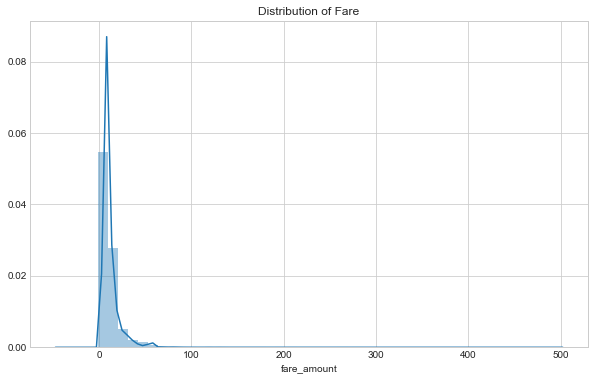

In [9]:
plt.figure(figsize = (10, 6))
sns.distplot(df_train['fare_amount']);
plt.title('Distribution of Fare');

In [10]:
print(f"There are {len(df_train[df_train['fare_amount'] < 0])} negative fares.")
print(f"There are {len(df_train[df_train['fare_amount'] == 0])} $0 fares.")
print(f"There are {len(df_train[df_train['fare_amount'] > 200])} fares greater than $200.")

There are 21 negative fares.
There are 14 $0 fares.
There are 26 fares greater than $200.


In [11]:
# Remove negative fare amount
df_train = df_train.drop(df_train[df_train['fare_amount']<0].index, axis=0)
print(f"There are {len(df_train[df_train['fare_amount'] < 0])} negative fares.")

There are 0 negative fares.


In [12]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,499974.000000,499974.000000,499974.000000,499974.000000,499974.000000,499974.000000
mean,11.358926,-72.520031,39.920315,-72.522523,39.916572,1.683440
std,9.915433,11.856692,8.073485,11.797161,7.390940,1.307383
min,0.000000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000
25%,6.000000,-73.992048,40.734917,-73.991382,40.734057,1.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768134,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


In [13]:
# 0 fare doesn't seem to be reasonable, and definitely not 500
# will assume $2.50 is the minimum, and cap it at $250

df_train = df_train[df_train['fare_amount'].between(left = 2.5, right = 250)]

In [14]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,499944.000000,499944.000000,499944.000000,499944.000000,499944.000000,499944.000000
mean,11.351715,-72.520094,39.920347,-72.522739,39.916683,1.683469
std,9.758133,11.856599,8.073528,11.796618,7.390728,1.307413
min,2.500000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000
25%,6.000000,-73.992048,40.734917,-73.991382,40.734057,1.000000
50%,8.500000,-73.981785,40.752670,-73.980127,40.753152,1.000000
75%,12.500000,-73.967119,40.767075,-73.963575,40.768133,2.000000
max,250.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


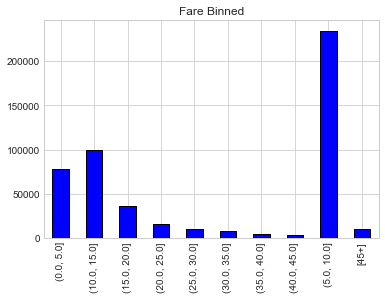

In [15]:
# Bin the fare and convert to string
df_train['fare-bin'] = pd.cut(df_train['fare_amount'], bins = list(range(0, 50, 5))).astype(str)

# try to fix the bin location and orders
# Uppermost bin
df_train.loc[df_train['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

# Adjust bin so the sorting is correct
df_train.loc[df_train['fare-bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'

df_train['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Fare Binned');


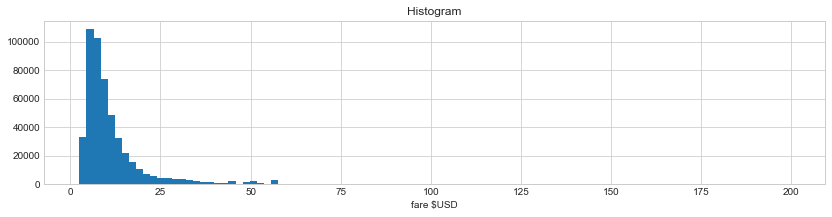

In [16]:
# plot histogram of fare
df_train[df_train.fare_amount<200].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');

In [17]:
# It seems like the max passenger_count is kinda off with 208
# Logically it seems like a cab would only make sense to hold at most 6 passenger, we will remove anything above it.

df_train = df_train.loc[df_train['passenger_count'] <= 6]

In [18]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,499944.000000,499944.000000,499944.000000,499944.000000,499944.000000,499944.000000
mean,11.351715,-72.520094,39.920347,-72.522739,39.916683,1.683469
std,9.758133,11.856599,8.073528,11.796618,7.390728,1.307413
min,2.500000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000
25%,6.000000,-73.992048,40.734917,-73.991382,40.734057,1.000000
50%,8.500000,-73.981785,40.752670,-73.980127,40.753152,1.000000
75%,12.500000,-73.967119,40.767075,-73.963575,40.768133,2.000000
max,250.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


In [19]:
df_train.shape

(499944, 9)

In [20]:
# Latitudes range from -90 to 90
# Longitudes range from -180 to 180.
# We will remove anything outside that range

In [21]:
df_train = df_train.drop((df_train[df_train['pickup_latitude']<-90]).index |(df_train[df_train['pickup_latitude']>90]).index, axis=0)


In [22]:
df_train = df_train.drop((df_train[df_train['dropoff_latitude']<-90]).index |(df_train[df_train['dropoff_latitude']>90]).index, axis=0)


In [23]:
df_train = df_train.drop((df_train[df_train['pickup_longitude']<-180]).index |(df_train[df_train['pickup_longitude']>180]).index, axis=0)


In [24]:
df_train = df_train.drop((df_train[df_train['dropoff_longitude']<-180]).index |(df_train[df_train['dropoff_longitude']>180]).index, axis=0)


In [25]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,499925.000000,499925.000000,499925.000000,499925.000000,499925.000000,499925.000000
mean,11.351689,-72.510832,39.922970,-72.507378,39.922214,1.683471
std,9.758063,10.416053,6.102066,10.423757,6.105933,1.307403
min,2.500000,-128.175950,-74.016195,-121.391248,-74.035197,0.000000
25%,6.000000,-73.992047,40.734917,-73.991382,40.734057,1.000000
50%,8.500000,-73.981785,40.752670,-73.980127,40.753152,1.000000
75%,12.500000,-73.967119,40.767075,-73.963575,40.768133,2.000000
max,250.000000,40.812887,69.400000,40.851027,73.997265,6.000000


In [26]:
df_train.shape

(499925, 9)

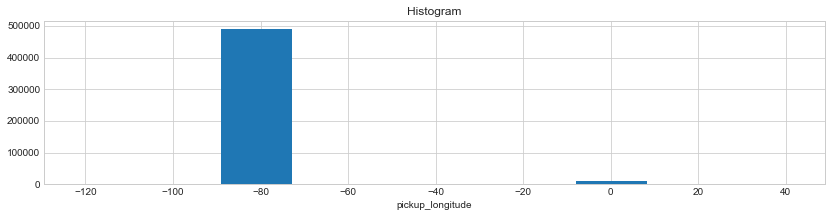

In [27]:
# plot histogram of fare
df_train.dropoff_longitude.hist(bins=10, figsize=(14,3))
plt.xlabel('pickup_longitude')
plt.title('Histogram');

In [28]:
# latitude of 0 seems weird, let's drop it
df_train = df_train.drop((df_train[df_train['pickup_longitude'] == 0]).index, axis=0)


Text(0, 0.5, 'Frequency')

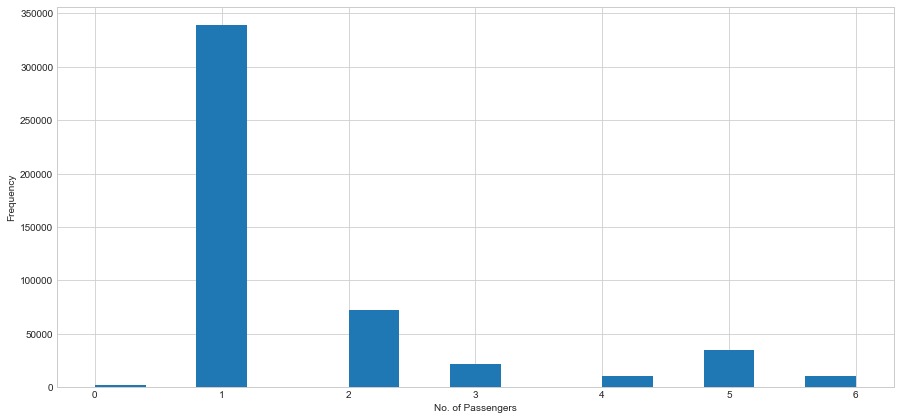

In [29]:
#Does the number of passengers affect the fare?

plt.figure(figsize=(15,7))
plt.hist(df_train['passenger_count'], bins=15)
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

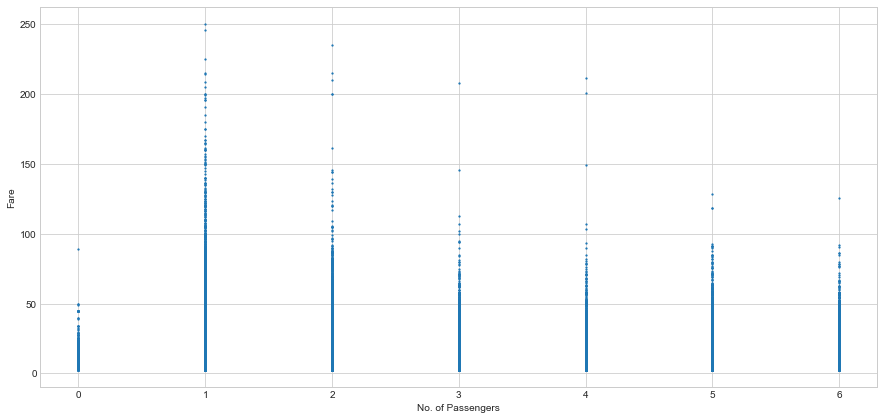

In [30]:
plt.figure(figsize=(15,7))
plt.scatter(x=df_train['passenger_count'], y=df_train['fare_amount'], s=1.5)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')

In [31]:
# It doesn't seems like the passenger count affects the the fare price.

Location Data

In [32]:
df_test =  pd.read_csv('test.csv')
df_test.head(5)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [33]:
# minimum and maximum longitude test set
min(df_test.pickup_longitude.min(), df_test.dropoff_longitude.min()), \
max(df_test.pickup_longitude.max(), df_test.dropoff_longitude.max())

(-74.263242, -72.986532)

In [34]:
# minimum and maximum latitude test
min(df_test.pickup_latitude.min(), df_test.dropoff_latitude.min()), \
max(df_test.pickup_latitude.max(), df_test.dropoff_latitude.max())

(40.568973, 41.709555)

In [35]:
# this function will also be used with the test set below
# Creating a boundingbox
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')


In [36]:
print('Old size: %d' % len(df_train))
df_train = df_train[select_within_boundingbox(df_train, BB)]
print('New size: %d' % len(df_train))

Old size: 490496
New size: 489438


In [37]:
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

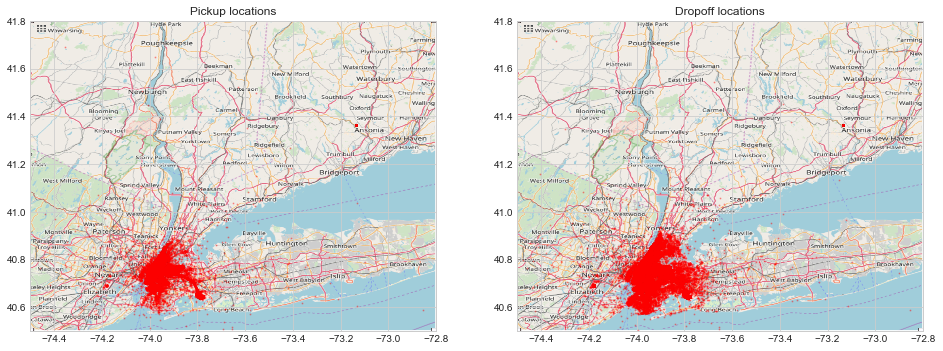

In [38]:
plot_on_map(df_train, BB, nyc_map, s=1, alpha=0.3)

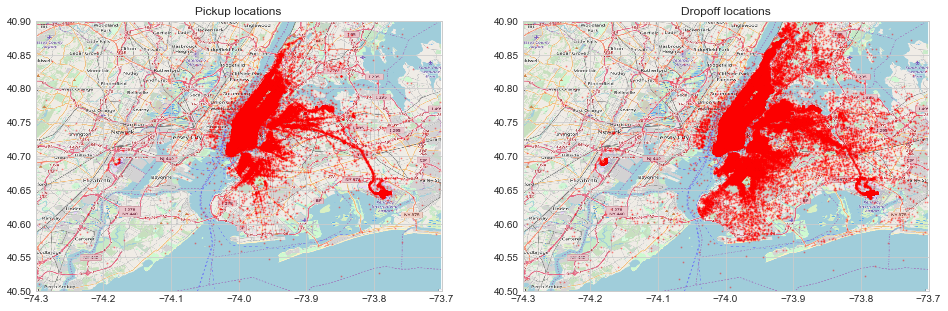

In [39]:
plot_on_map(df_train, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

In [40]:
def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = select_within_boundingbox(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.01, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=0.01, alpha=0.5)

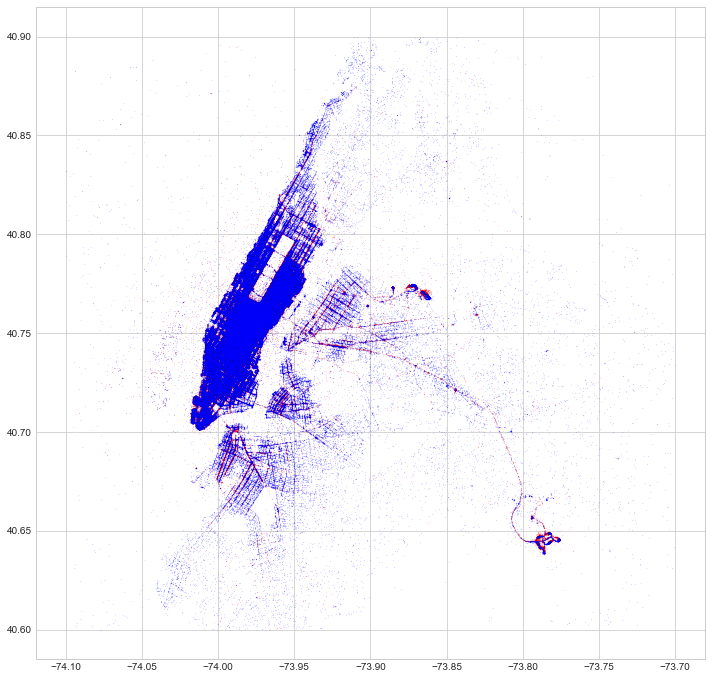

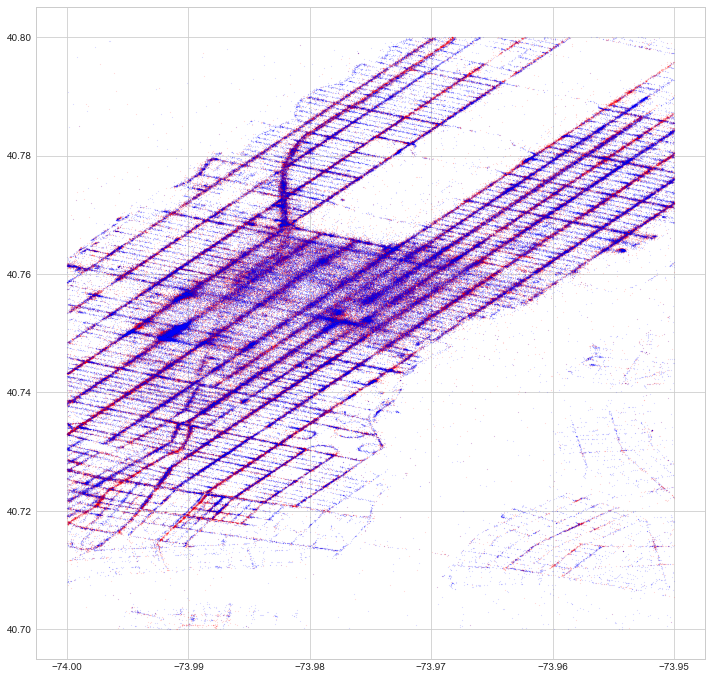

In [41]:
plot_hires(df_train, (-74.1, -73.7, 40.6, 40.9))
plot_hires(df_train, (-74, -73.95, 40.7, 40.8))

In [42]:
def haversine_distance(lat1, long1, lat2, long2):
    data = [df_train, df_test]; 
    for i in data:
        R = 6371  
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        i['H_Distance'] = d
    return d

In [43]:
haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

0        2.323260
1        2.425353
2        0.618628
3        1.961033
4        5.387301
          ...    
9909     2.124874
9910     3.270969
9911    19.183941
9912     8.343486
9913     1.180825
Length: 9914, dtype: float64

In [44]:
df_train.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,H_Distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,"(0.0, 5.0]",1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,"(15.0, 20.0]",8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,"(5.0, 10.0]",1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,"(5.0, 10.0]",2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,"(5.0, 10.0]",1.999157
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45+00:00,-74.000964,40.731630,-73.972892,40.758233,1,"(10.0, 15.0]",3.787239
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00+00:00,-73.980002,40.751662,-73.973802,40.764842,1,"(5.0, 10.0]",1.555807
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00+00:00,-73.951300,40.774138,-73.990095,40.751048,1,"(15.0, 20.0]",4.155444
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00+00:00,-74.006462,40.726713,-73.993078,40.731628,1,"(5.0, 10.0]",1.253232
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00+00:00,-73.980658,40.733873,-73.991540,40.758138,2,"(5.0, 10.0]",2.849627


In [45]:
df_test.head(10)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,2.323260
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,2.425353
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1,0.618628
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1,1.961033
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1,5.387301
5,2012-12-01 21:12:12.0000005,2012-12-01 21:12:12 UTC,-73.960983,40.765547,-73.979177,40.740053,1,3.222549
6,2011-10-06 12:10:20.0000001,2011-10-06 12:10:20 UTC,-73.949013,40.773204,-73.959622,40.770893,1,0.929601
7,2011-10-06 12:10:20.0000003,2011-10-06 12:10:20 UTC,-73.777282,40.646636,-73.985083,40.759368,1,21.540102
8,2011-10-06 12:10:20.0000002,2011-10-06 12:10:20 UTC,-74.014099,40.709638,-73.995106,40.741365,1,3.873962
9,2014-02-18 15:22:20.0000002,2014-02-18 15:22:20 UTC,-73.969582,40.765519,-73.980686,40.770725,1,1.099794


In [46]:
df_train['pickup_datetime']  = pd.to_datetime(df_train['pickup_datetime'])

In [47]:
df_test['pickup_datetime']  = pd.to_datetime(df_test['pickup_datetime'])

In [48]:
data = [df_train, df_test]
for i in data:
    i['Year'] = i['pickup_datetime'].dt.year
    i['Month'] = i['pickup_datetime'].dt.month
    i['Date'] = i['pickup_datetime'].dt.day
    i['Day of Week'] = i['pickup_datetime'].dt.dayofweek
    i['Hour'] = i['pickup_datetime'].dt.hour

Text(0, 0.5, 'Frequency')

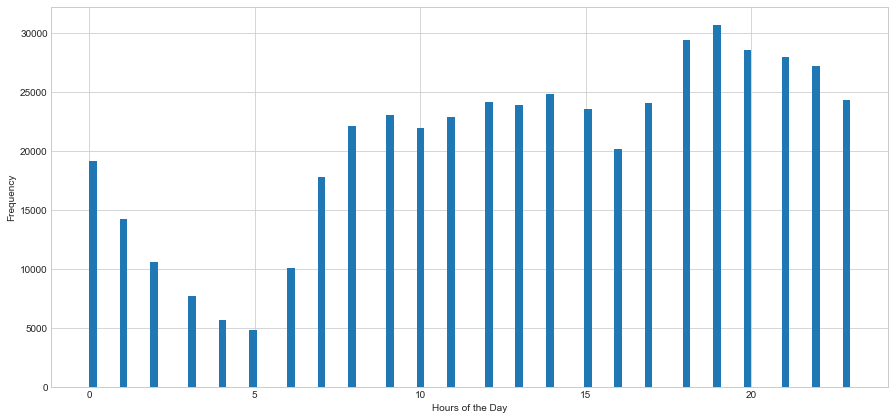

In [49]:
plt.figure(figsize=(15,7))
plt.hist(df_train['Hour'], bins=100)
plt.xlabel('Hours of the Day')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

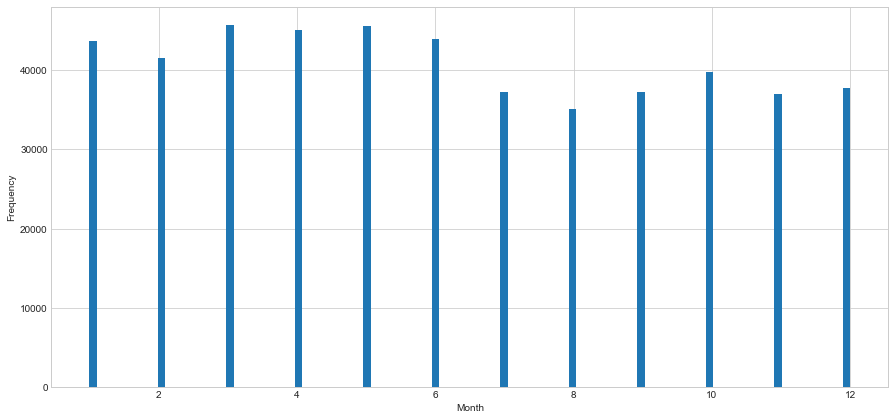

In [50]:
plt.figure(figsize=(15,7))
plt.hist(df_train['Month'], bins=100)
plt.xlabel('Month')
plt.ylabel('Frequency')

In [51]:
bins_0 = df_train.loc[(df_train['H_Distance'] == 0), ['H_Distance']]
bins_1 = df_train.loc[(df_train['H_Distance'] > 0) & (df_train['H_Distance'] <= 10),['H_Distance']]
bins_2 = df_train.loc[(df_train['H_Distance'] > 10) & (df_train['H_Distance'] <= 50),['H_Distance']]
bins_3 = df_train.loc[(df_train['H_Distance'] > 50) & (df_train['H_Distance'] <= 100),['H_Distance']]
bins_4 = df_train.loc[(df_train['H_Distance'] > 100) & (df_train['H_Distance'] <= 200),['H_Distance']]
bins_5 = df_train.loc[(df_train['H_Distance'] > 200) & (df_train['H_Distance'] <= 300),['H_Distance']]
bins_6 = df_train.loc[(df_train['H_Distance'] > 300),['H_Distance']]
bins_0['bins'] = '0'
bins_1['bins'] = '0-10'
bins_2['bins'] = '11-50'
bins_3['bins'] = '51-100'
bins_4['bins'] = '100-200'
bins_5['bins'] = '201-300'
bins_6['bins'] = '>300'
dist_bins =pd.concat([bins_0,bins_1,bins_2,bins_3,bins_4,bins_5,bins_6])
#len(dist_bins)
dist_bins.columns

Index(['H_Distance', 'bins'], dtype='object')

In [52]:
from collections import Counter
Counter(dist_bins['bins'])

Counter({'0': 5219,
         '0-10': 459469,
         '11-50': 24665,
         '51-100': 65,
         '100-200': 20})

In [53]:
df_train.loc[(df_train['H_Distance']==0) & (df_train['fare_amount']!=0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,H_Distance,Year,Month,Date,Day of Week,Hour
105,2009-03-25 00:08:52.0000001,52.0,2009-03-25 00:08:52+00:00,-74.035839,40.747320,-74.035839,40.747320,1,[45+],0.0,2009,3,25,2,0
191,2014-01-08 21:55:58.0000006,6.5,2014-01-08 21:55:58+00:00,-73.998488,40.726303,-73.998488,40.726303,1,"(5.0, 10.0]",0.0,2014,1,8,2,21
270,2012-08-25 01:53:42.0000005,7.5,2012-08-25 01:53:42+00:00,-73.995892,40.746454,-73.995892,40.746454,1,"(5.0, 10.0]",0.0,2012,8,25,5,1
290,2009-12-14 12:33:00.00000075,6.9,2009-12-14 12:33:00+00:00,-73.982432,40.745747,-73.982432,40.745747,1,"(5.0, 10.0]",0.0,2009,12,14,0,12
396,2014-03-12 18:12:44.0000006,12.0,2014-03-12 18:12:44+00:00,-73.844904,40.736318,-73.844904,40.736318,1,"(10.0, 15.0]",0.0,2014,3,12,2,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499566,2011-05-26 15:13:00.000000193,4.5,2011-05-26 15:13:00+00:00,-73.965385,40.759243,-73.965385,40.759243,1,"(0.0, 5.0]",0.0,2011,5,26,3,15
499575,2012-04-24 11:43:00.00000017,7.3,2012-04-24 11:43:00+00:00,-73.977893,40.756397,-73.977893,40.756397,1,"(5.0, 10.0]",0.0,2012,4,24,1,11
499590,2014-03-05 15:33:36.0000001,3.0,2014-03-05 15:33:36+00:00,-73.985299,40.760519,-73.985299,40.760519,1,"(0.0, 5.0]",0.0,2014,3,5,2,15
499703,2011-07-18 08:49:00.000000122,7.7,2011-07-18 08:49:00+00:00,-73.850235,40.733578,-73.850235,40.733578,1,"(5.0, 10.0]",0.0,2011,7,18,0,8


In [54]:
scenario_4 = df_train.loc[(df_train['H_Distance']==0) & (df_train['fare_amount']!=0)]

In [55]:
len(scenario_4)

5219

In [56]:
scenario_4.loc[(scenario_4['fare_amount']<=3.0)&(scenario_4['H_Distance']==0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,H_Distance,Year,Month,Date,Day of Week,Hour
503,2010-01-19 01:10:00.00000012,2.5,2010-01-19 01:10:00+00:00,-73.998720,40.624708,-73.998720,40.624708,1,"(0.0, 5.0]",0.0,2010,1,19,1,1
657,2009-08-25 01:50:21.0000001,2.5,2009-08-25 01:50:21+00:00,-73.986410,40.763350,-73.986410,40.763350,1,"(0.0, 5.0]",0.0,2009,8,25,1,1
1419,2013-07-21 00:10:23.0000001,2.5,2013-07-21 00:10:23+00:00,-73.956556,40.779828,-73.956556,40.779828,1,"(0.0, 5.0]",0.0,2013,7,21,6,0
1774,2012-08-27 15:24:00.0000007,2.5,2012-08-27 15:24:00+00:00,-73.950282,40.701282,-73.950282,40.701282,1,"(0.0, 5.0]",0.0,2012,8,27,0,15
4367,2014-01-13 16:14:48.0000001,2.5,2014-01-13 16:14:48+00:00,-73.948410,40.744969,-73.948410,40.744969,1,"(0.0, 5.0]",0.0,2014,1,13,0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497747,2015-04-29 15:58:04.0000006,2.5,2015-04-29 15:58:04+00:00,-73.934875,40.740971,-73.934875,40.740971,1,"(0.0, 5.0]",0.0,2015,4,29,2,15
498475,2013-10-28 03:30:06.0000001,2.5,2013-10-28 03:30:06+00:00,-73.894944,40.754407,-73.894944,40.754407,4,"(0.0, 5.0]",0.0,2013,10,28,0,3
498984,2012-08-09 13:39:43.0000004,2.5,2012-08-09 13:39:43+00:00,-73.974394,40.789899,-73.974394,40.789899,1,"(0.0, 5.0]",0.0,2012,8,9,3,13
499116,2009-07-06 02:37:39.0000001,2.5,2009-07-06 02:37:39+00:00,-73.978258,40.684624,-73.978258,40.684624,1,"(0.0, 5.0]",0.0,2009,7,6,0,2


In [57]:
scenario_4.loc[(scenario_4['fare_amount']>3.0)&(scenario_4['H_Distance']==0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,H_Distance,Year,Month,Date,Day of Week,Hour
105,2009-03-25 00:08:52.0000001,52.0,2009-03-25 00:08:52+00:00,-74.035839,40.747320,-74.035839,40.747320,1,[45+],0.0,2009,3,25,2,0
191,2014-01-08 21:55:58.0000006,6.5,2014-01-08 21:55:58+00:00,-73.998488,40.726303,-73.998488,40.726303,1,"(5.0, 10.0]",0.0,2014,1,8,2,21
270,2012-08-25 01:53:42.0000005,7.5,2012-08-25 01:53:42+00:00,-73.995892,40.746454,-73.995892,40.746454,1,"(5.0, 10.0]",0.0,2012,8,25,5,1
290,2009-12-14 12:33:00.00000075,6.9,2009-12-14 12:33:00+00:00,-73.982432,40.745747,-73.982432,40.745747,1,"(5.0, 10.0]",0.0,2009,12,14,0,12
396,2014-03-12 18:12:44.0000006,12.0,2014-03-12 18:12:44+00:00,-73.844904,40.736318,-73.844904,40.736318,1,"(10.0, 15.0]",0.0,2014,3,12,2,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499502,2009-07-16 21:16:00.00000057,5.7,2009-07-16 21:16:00+00:00,-73.977183,40.743522,-73.977183,40.743522,2,"(5.0, 10.0]",0.0,2009,7,16,3,21
499566,2011-05-26 15:13:00.000000193,4.5,2011-05-26 15:13:00+00:00,-73.965385,40.759243,-73.965385,40.759243,1,"(0.0, 5.0]",0.0,2011,5,26,3,15
499575,2012-04-24 11:43:00.00000017,7.3,2012-04-24 11:43:00+00:00,-73.977893,40.756397,-73.977893,40.756397,1,"(5.0, 10.0]",0.0,2012,4,24,1,11
499703,2011-07-18 08:49:00.000000122,7.7,2011-07-18 08:49:00+00:00,-73.850235,40.733578,-73.850235,40.733578,1,"(5.0, 10.0]",0.0,2011,7,18,0,8


In [58]:
scenario_4_sub = scenario_4.loc[(scenario_4['fare_amount']>3.0)&(scenario_4['H_Distance']==0)]

In [59]:
len(scenario_4_sub)


4775

In [60]:
scenario_4_sub['H_Distance'] = scenario_4_sub.apply(
lambda row: ((row['fare_amount']-2.50)/1.56), axis=1
)

C:\Users\shaun\Anaconda3\envs\pythondata\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [61]:
df_train.update(scenario_4_sub)

In [62]:
df_train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'fare-bin', 'H_Distance', 'Year', 'Month', 'Date',
       'Day of Week', 'Hour'],
      dtype='object')

In [63]:
df_test.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'H_Distance', 'Year', 'Month', 'Date', 'Day of Week', 'Hour'],
      dtype='object')

In [127]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [128]:
df_train_copy.shape

(489438, 15)

In [129]:
df_test_copy.shape

(9914, 13)

In [130]:
df_train_copy = df_train_copy.drop(['key','pickup_datetime', 'fare-bin'], axis = 1)
df_test_copy = df_test_copy.drop(['key','pickup_datetime'], axis = 1)

In [131]:
df_train_copy.shape

(489438, 12)

In [132]:
df_test_copy.shape

(9914, 11)

In [133]:
# Making the model

features = ['Month', 'Date', 'Day of Week','Year', 'Hour', 'H_Distance', 'passenger_count']

X = df_train[features].values
y = df_train['fare_amount'].values

In [134]:
X.shape, y.shape

((489438, 7), (489438,))

In [135]:
df_train["H_Distance"].sort_values(ascending=False)

202499    142.628205
320161    116.987179
1335      113.782051
222208    110.833077
364887    105.448718
             ...    
236708      0.000000
377221      0.000000
106088      0.000000
106102      0.000000
275698      0.000000
Name: H_Distance, Length: 489438, dtype: float64

In [136]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,H_Distance,Year,Month,Date,Day of Week,Hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0,"(0.0, 5.0]",1.030764,2009.0,6.0,15.0,0.0,17.0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0,"(15.0, 20.0]",8.450134,2010.0,1.0,5.0,1.0,16.0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0,"(5.0, 10.0]",1.389525,2011.0,8.0,18.0,3.0,0.0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0,"(5.0, 10.0]",2.799270,2012.0,4.0,21.0,5.0,4.0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0,"(5.0, 10.0]",1.999157,2010.0,3.0,9.0,1.0,7.0


In [137]:
# define some handy analysis support function
from sklearn.metrics import mean_squared_error, explained_variance_score

def plot_prediction_analysis(y, y_pred, figsize=(10,4), title=''):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].scatter(y, y_pred)
    mn = min(np.min(y), np.min(y_pred))
    mx = max(np.max(y), np.max(y_pred))
    axs[0].plot([mn, mx], [mn, mx], c='red')
    axs[0].set_xlabel('$y$')
    axs[0].set_ylabel('$\hat{y}$')
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    evs = explained_variance_score(y, y_pred)
    axs[0].set_title('rmse = {:.2f}, evs = {:.2f}'.format(rmse, evs))
    
    axs[1].hist(y-y_pred, bins=50)
    avg = np.mean(y-y_pred)
    std = np.std(y-y_pred)
    axs[1].set_xlabel('$y - \hat{y}$')
    axs[1].set_title('Histrogram prediction error, $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(avg, std))
    
    if title!='':
        fig.suptitle(title)

In [138]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)

In [139]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

model_lin = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ))
model_lin.fit(X_train, y_train)



Pipeline(memory=None,
         steps=[('standard_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lin_reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

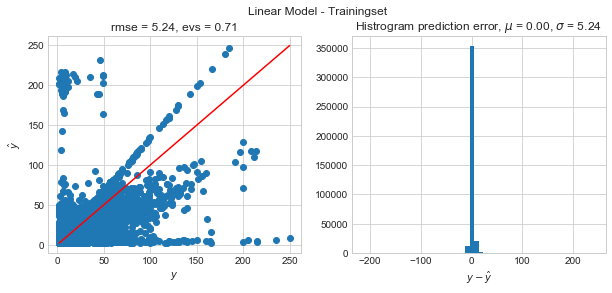

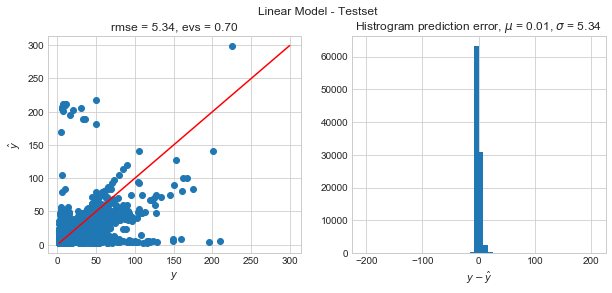

In [140]:
y_train_pred = model_lin.predict(X_train)
plot_prediction_analysis(y_train, y_train_pred, title='Linear Model - Trainingset')

y_valid_pred = model_lin.predict(X_valid)
plot_prediction_analysis(y_valid, y_valid_pred, title='Linear Model - Testset')

In [141]:
model_lin.score(X_valid, y_valid)

0.6962242872627162

In [142]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()


In [143]:
rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [144]:
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=51, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=2, oob_score=True, random_state=None,
                      verbose=0, warm_start=False)

In [145]:
rf.fit(X_train, y_train)

C:\Users\shaun\Anaconda3\envs\pythondata\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=51, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [146]:
rf.score(X_valid, y_valid)

0.7992646660678266

In [101]:
pickle.dump(rf, open("model.pkl", "wb"))

In [102]:
model = pickle.load(open("model.pkl", "rb"))
print(model.predict([[2.0, 1.389525, 2011, 8.0, 18.0, 3.0, 0.0]]))

[9.54]


In [103]:
import sklearn

In [104]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.3.
